#### В данном блокноте представлены несколько методов детекции дрейфа данных и дрейфа концепций. Статья по этой теме будет выпущена на хабре во второй половине июля 2022.

In [22]:
import numpy as np
from numpy import quantile, random, where
import pandas as pd
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, gc, warnings, random

## Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import IsolationForest
import eli5

## river
from river import drift

## Turn off warnings
warnings.filterwarnings('ignore')

## SEEDer
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

seed_everything()

%matplotlib inline

В этом примере мы создадим синтетический поток данных и поток ошибок модели, объединив 3 распределения по 1000 образцов в каждом. Далее на этом потоке продемонстрируем работу некоторых методов детекции дрейфа данных и дрейфа концепций. Т.е. методы должны определить сдвиг распределений на 1000 и 2000 элементах.

In [3]:
# Для наглядности создадим синтетический поток данных, объединив 3 распределения по 1000 образцов в каждом
random_state = np.random.RandomState(seed=42)
data_train = random_state.normal(0.8, 0.05, 1000)
data_prom1 = random_state.normal(0.4, 0.02, 1000)
data_prom2 = random_state.normal(0.6, 0.1, 1000)

# Поток данных по ошибкам модели (1 - модель ошиблась, 0 - модель не ошиблась)
true_pred1 = np.random.binomial(1, .2, 1000)
true_pred2 = np.random.binomial(1, .3, 1000)
true_pred3 = np.random.binomial(1, .8, 1000)

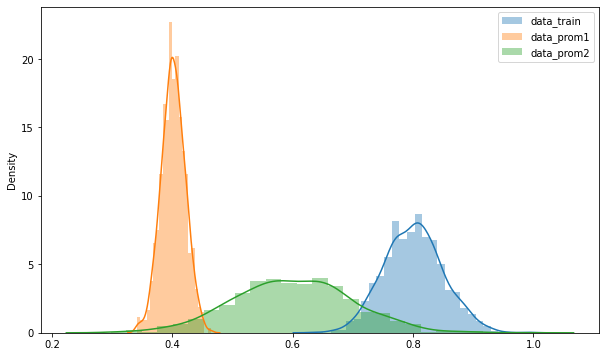

In [4]:
fig = plt.figure(figsize=(10,6))
sns.distplot(data_train, label='data_train')
sns.distplot(data_prom1, label='data_prom1')
sns.distplot(data_prom2, label='data_prom2')
plt.legend();

In [5]:
# Объединим данные для имитации потока данных с двумя дрейфами
data_stream = np.concatenate((data_train, data_prom1, data_prom2))
true_pred_stream = np.concatenate((true_pred1, true_pred2, true_pred3))
df = pd.DataFrame({'data': data_stream,'true_pred':true_pred_stream,})

In [7]:
df.head()

,data,true_pred
0,0.824836,0
1,0.793087,0
2,0.832384,0
3,0.876151,0
4,0.788292,0


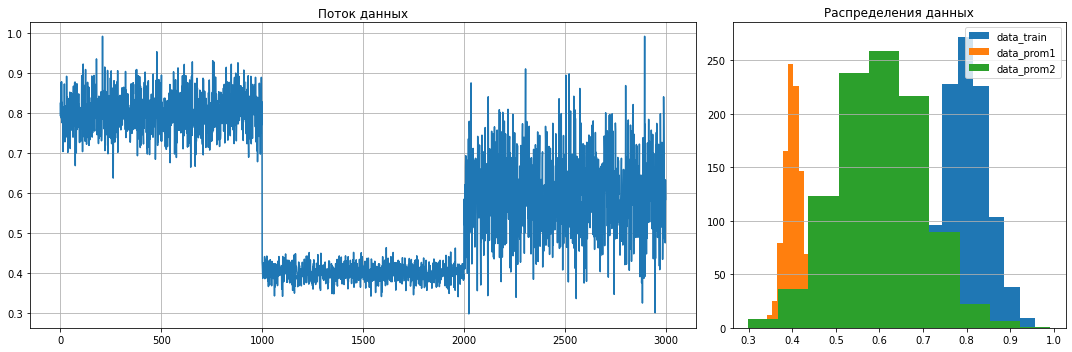

In [8]:
fig = plt.figure(figsize=(15,5), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax1, ax2 = plt.subplot(gs[0], title='Поток данных'), plt.subplot(gs[1], title='Распределения данных')
ax1.grid()
ax1.plot(data_stream)
ax2.grid(axis='y')
ax2.hist(data_train, label='data_train')
ax2.hist(data_prom1, label='data_prom1')
ax2.hist(data_prom2, label='data_prom2')
ax2.legend()
plt.show()

In [28]:
# функция для визуализации детекции дрейфа в потоковых данных
def drift_detecton_plot(data_stream, drift_detector, data_plot):
    drifts = []
    for i, val in enumerate(data_stream):
        drift_detector.update(val)   # Данные обрабатываются по одной выборке за раз
        if drift_detector.change_detected:
            # Детектор дрейфа указывает после каждой выборки, есть ли дрейф в данных.
            print(f'Зафиксирован дрейф на индексе {i}')
            drifts.append(i)
            drift_detector.reset()
    fig = plt.figure(figsize=(10,5), tight_layout=True)
    plt.title('Детекция дрейфа в потоке данных')
    plt.xlabel('Time')
    plt.plot(data_plot, label='Поток данных')
    plt.vlines(drifts, ymin=0.3, ymax=1, colors='red', lw=2, zorder=5, label='Зона детекции дрейфа')
    plt.legend()
    plt.show()

### ADWIN

Мы будем использовать метод обнаружения дрейфа ADaptive WINdowing ( ADWIN). Помните, что цель состоит в том, чтобы указать, что дрейф произошел после выборок 1000 и 2000 в синтетическом потоке данных.

Зафиксирован дрейф на индексе 1055
Зафиксирован дрейф на индексе 2079


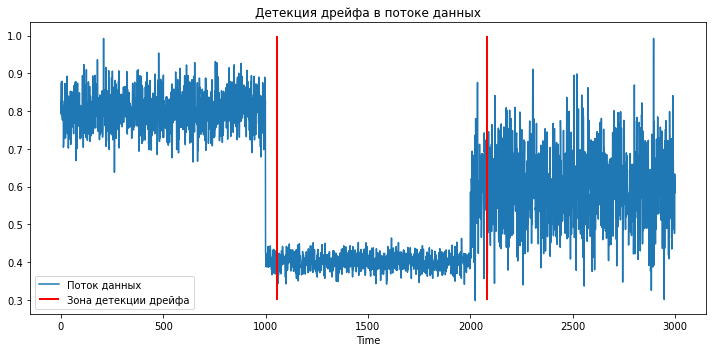

In [29]:
drift_detecton_plot(data_stream, drift.ADWIN(), data_stream)

### DDM

Зафиксирован дрейф на индексе 1326
Зафиксирован дрейф на индексе 2175


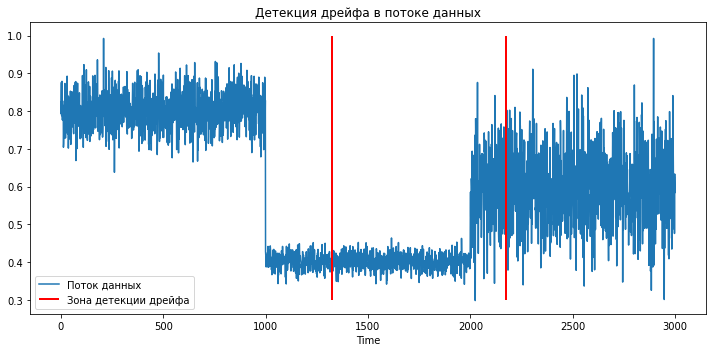

In [11]:
drift_detecton_plot(true_pred_stream, drift.DDM(), data_stream)

### EDDM

Зафиксирован дрейф на индексе 163
Зафиксирован дрейф на индексе 395
Зафиксирован дрейф на индексе 547
Зафиксирован дрейф на индексе 850
Зафиксирован дрейф на индексе 1058
Зафиксирован дрейф на индексе 1190
Зафиксирован дрейф на индексе 1278
Зафиксирован дрейф на индексе 1487
Зафиксирован дрейф на индексе 1584
Зафиксирован дрейф на индексе 1820
Зафиксирован дрейф на индексе 1991
Зафиксирован дрейф на индексе 2034


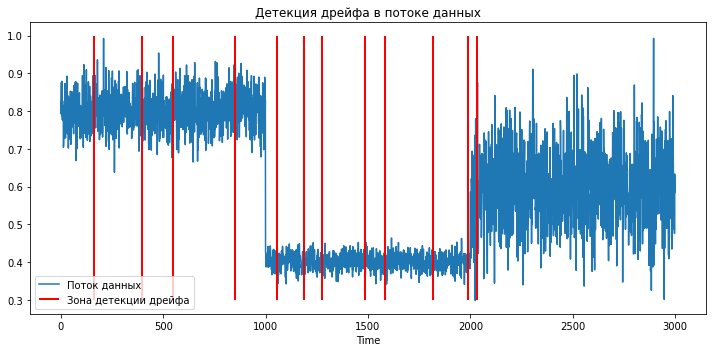

In [12]:
drift_detecton_plot(true_pred_stream, drift.EDDM(), data_stream)

### PageHinkley

Зафиксирован дрейф на индексе 1326
Зафиксирован дрейф на индексе 2098


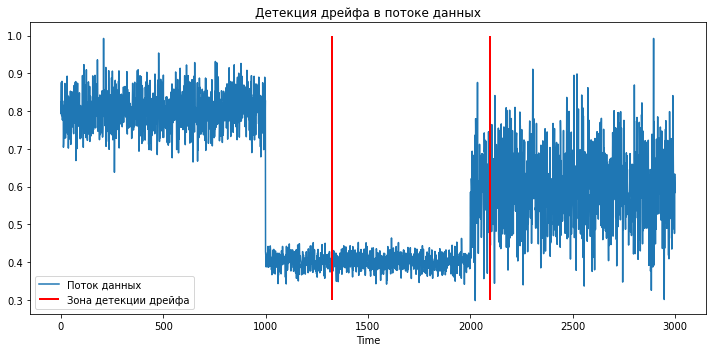

In [13]:
drift_detecton_plot(true_pred_stream, drift.PageHinkley(), data_stream)

### Model-Based Approach

Создадим датасет с 2мя признаками: дрейфующим и стабильным.

Ту часть, где дрейфующий признак имеет одно распределение выделим таргетом 1, после смены распределения - таргетом 0.

In [14]:
data_stable_train = random_state.normal(0.5, 0.05, 1000)
data_stable_prod = random_state.normal(0.5, 0.05, 1000)

df_train = pd.DataFrame({'Drifted_data': data_train, 'Stable_data': data_stable_train, 'target': 1})
df_prod = pd.DataFrame({'Drifted_data': data_prom1, 'Stable_data': data_stable_prod, 'target': 0})
all_df = pd.concat([df_train, df_prod]).reset_index(drop=True)

Обучим модель распознавать один пакет данных от другого

In [71]:
model = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=17)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
adv_validation_scores = cross_val_score(model, all_df[['Drifted_data', 'Stable_data']], all_df['target'], cv=skf, n_jobs=4,
                                       scoring='roc_auc')
adv_validation_scores

array([1., 1., 1., 1., 1.])

In [72]:
model.fit(all_df[['Drifted_data', 'Stable_data']], all_df['target'])

RandomForestClassifier(n_jobs=4, random_state=17)

Мы видим, что два этих пакета данных различны, при этом Drifted_data имеет высокую значимость в данном различии:

In [73]:
eli5.show_weights(estimator=model, feature_names=list(all_df[['Drifted_data', 'Stable_data']]))

Weight,Feature
0.9902 ± 0.0295,Drifted_data
0.0098 ± 0.0295,Stable_data


 ### Kolmogorov-Smirnov (K-S) test:

In [74]:
from scipy import stats
p_value = 0.05

test = stats.ks_2samp(data_train, data_prom1)
if test[1] < p_value:
    print('Распределения двух наборов данных различны')
else:
    print('В распределении обоих наборов данных нет изменений или сдвигов')
test

Распределения двух наборов данных различны


KstestResult(statistic=1.0, pvalue=0.0)

### Population Stability Index:

а) PSI<=0,1: в распределении обоих наборов данных нет изменений или сдвигов.

б) 0,1< PSI<0,2: небольшое изменение или сдвиг.

в) PSI>0,2: между обоими наборами данных произошел значительный сдвиг в распределении.

In [75]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    def psi(expected_array, actual_array, buckets):
        # TODO: input, min, max
        def scale_range (data_input, min_val, max_val):
            data_input += -(np.min(data_input))
            data_input /= np.max(data_input) / (max_val - min_val)
            data_input += min_val
            return data_input
        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
        breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)
        def sub_psi(e_perc, a_perc):
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001
            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)
        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i])
                                             for i in range(0, len(expected_percents)))
        return(psi_value)
    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])
    for i in range(0, len(psi_values)):
        psi_values = psi(expected, actual, buckets)
    if psi_values <= 0.1:
        print('В распределении обоих наборов данных нет изменений или сдвигов')
    elif psi_values > 0.2 :
        print('Распределения двух наборов данных имеют значительные различия')
    else:
        print('В распределении наборов данных есть небольшое изменение или сдвиг')
    return(psi_values)

In [76]:
calculate_psi(data_train, data_prom1)

Распределения двух наборов данных имеют значительные различия


7.437140212812651

### Isolation Forest

Изучим возможность применения Isolation Forest в детекции дрейфа данных

In [18]:
# Выделим обучающий набор данных и проверим работу модели на условно промышленном потоке
data_prom = np.concatenate((data_prom1, data_prom2)).reshape([-1,1])
data_train_IS = data_train.reshape([-1,1])

In [15]:
IS = IsolationForest(random_state=0).fit(data_train_IS)
IS_drift_predict = clf.predict(data_prom)

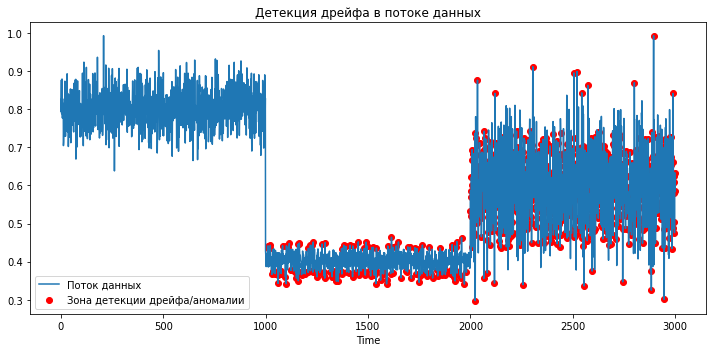

In [58]:
outlier_index = where(IS_drift_predict==-1)
values = data_prom[outlier_index]

fig = plt.figure(figsize=(10,5), tight_layout=True)
plt.title('Детекция дрейфа в потоке данных')
plt.xlabel('Time')
plt.plot(data_stream, label='Поток данных')
plt.scatter(np.array(outlier_index)+1000, values, color='r', label='Зона детекции дрейфа/аномалии')
# plt.vlines(np.array(outlier_index)+1000, ymin=0.3, ymax=1, colors='red', lw=2, zorder=5, label='Зона детекции дрейфа')
plt.legend()
plt.show()